In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training
--

Import the necessary packages

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=d51905839c5ccc4c34f78a027f3fad5abf10eadada078f36cf432890779eccc7
  Stored in directory: /home/vitis-ai-user/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Load the dataset

In [9]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset-20230621T112614Z-001/dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


[INFO] loading images...


/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [10]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


2023-06-22 03:41:08.810271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/cv2/../../lib64:/opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-06-22 03:41:08.810297: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-22 03:41:08.810314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-06-22 03:41:08.810519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

9420800/9406464 [==============================] - 1s 0us/step


In [12]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [13]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
98/98 [==============================] - 48s 458ms/step - loss: 0.4281 - accuracy: 0.8491 - val_loss: 0.1610 - val_accuracy: 0.9458
Epoch 2/20
98/98 [==============================] - 45s 453ms/step - loss: 0.1037 - accuracy: 0.9699 - val_loss: 0.1213 - val_accuracy: 0.9506
Epoch 3/20
98/98 [==============================] - 45s 456ms/step - loss: 0.0714 - accuracy: 0.9760 - val_loss: 0.0872 - val_accuracy: 0.9658
Epoch 4/20
98/98 [==============================] - 45s 459ms/step - loss: 0.0581 - accuracy: 0.9817 - val_loss: 0.1016 - val_accuracy: 0.9610
Epoch 5/20
98/98 [==============================] - 45s 454ms/step - loss: 0.0502 - accuracy: 0.9833 - val_loss: 0.0797 - val_accuracy: 0.9705
Epoch 6/20
98/98 [==============================] - 45s 453ms/step - loss: 0.0450 - accuracy: 0.9843 - val_loss: 0.1069 - val_accuracy: 0.9620
Epoch 7/20
98/98 [==============================] - 45s 459ms/step - loss: 0.0488 - accuracy: 0.9843 - val_loss: 0.081

In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       543
without_mask       0.99      0.97      0.98       509

    accuracy                           0.98      1052
   macro avg       0.98      0.98      0.98      1052
weighted avg       0.98      0.98      0.98      1052



In [16]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")



[INFO] saving mask detector model...


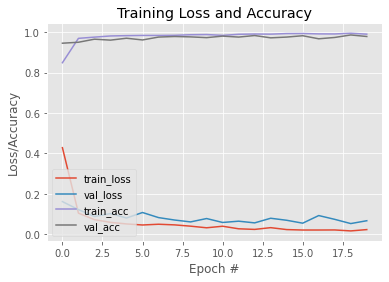

In [18]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


Running the model on images
---

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


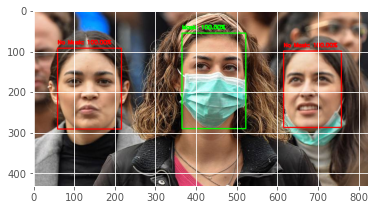

In [19]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["face_detector","res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.model")

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread("pic1.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.savefig("Output.png")
plt.show()

In [20]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [24]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = testX[1:1024], weight_bit=8, activation_bit=8)

quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = quantized_model.evaluate(testX , testY ,verbose=0, batch_size=1)
print(score)
print('last')
quantized_model.save('fmd_cs031.h5')

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 9s 975ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 74s 2s/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.
[5.587075710296631, 0.48669201135635376]
last
